In [296]:
#Import necessary modules

import pandas as pd
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
import warnings
warnings.simplefilter('ignore')
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


In [297]:
#Bring in the data CSV
data = "cardio_train.csv"
cardio_df = pd.read_csv(data, delimiter = ';')
cardio_df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [298]:
#Clean up age & drop the unneeded ID column
cardio1_df= cardio_df.drop(['id'],axis=1)
# cardio1_df.active[cardio1_df.active == 1] = "True"
# cardio1_df.active[cardio1_df.active == 0] = "False"
age_upd = cardio1_df['age'].div(365)
rounded_age = round(age_upd)
cardio1_df.update(rounded_age)

#Convert to US understood numbers & add column for BMI
weight_upd = round(cardio1_df['weight']*2.2)
height_upd = round(cardio1_df['height'].div(2.54))

cardio1_df.update(weight_upd)
cardio1_df.update(height_upd)
cardio1_df.head()

cardio1_df["BMI"] = (cardio1_df['weight']*703)/(cardio1_df["height"]*cardio1_df["height"])
cardio1_df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,50.0,2,66.0,136.0,110,80,1,1,0,0,1,0,21.948577
1,55.0,1,61.0,187.0,140,90,3,1,0,0,1,1,35.329481
2,52.0,1,65.0,141.0,130,70,3,1,0,0,0,1,23.461065
3,48.0,2,67.0,180.0,150,100,1,1,0,0,1,1,28.188906
4,48.0,1,61.0,123.0,100,60,1,1,0,0,0,0,23.238108


In [299]:
cardio1_encoded = pd.get_dummies(cardio1_df, columns=["cholesterol", "gender"])
cardio1_encoded.head()


,age,height,weight,ap_hi,ap_lo,gluc,smoke,alco,active,cardio,BMI,cholesterol_1,cholesterol_2,cholesterol_3,gender_1,gender_2
0,50.0,66.0,136.0,110,80,1,0,0,1,0,21.948577,1,0,0,0,1
1,55.0,61.0,187.0,140,90,1,0,0,1,1,35.329481,0,0,1,1,0
2,52.0,65.0,141.0,130,70,1,0,0,0,1,23.461065,0,0,1,1,0
3,48.0,67.0,180.0,150,100,1,0,0,1,1,28.188906,1,0,0,0,1
4,48.0,61.0,123.0,100,60,1,0,0,0,0,23.238108,1,0,0,1,0


In [300]:
#Assign x (data) and y (target)
#X = cardio1_encoded[['age', 'gender', 'height','weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'alco', 'active', 'smoke', 'BMI' ]]
X = cardio1_encoded.drop("cardio", axis=1)
y = cardio1_encoded["cardio"]
print(X.shape, y.shape)

(70000, 15) (70000,)


In [301]:
# Split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [302]:
#  XGBoost regressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
# Separate the target variable and rest of the variables using .iloc to subset the data.
#X, y = data.iloc[:,:-1],data.iloc[:,-1]
# convert the dataset into an optimized data structure called Dmatrix that XGBoost supports 
# and gives it acclaimed performance and efficiency gains. You will use this later in the tutorial.
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [303]:
#For classification problems, you would have used the XGBClassifier() class.
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [304]:
# Fit the regressor to the training set and make predictions on the test set using the familiar .fit() and .predict() methods.
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
preds

array([0.5964919 , 0.6179296 , 0.5953085 , ..., 0.41260093, 0.45408615,
       0.5845166 ], dtype=float32)

In [305]:
# use these parameters to build a 3-fold cross validation model by invoking XGBoost's
# cv() method and store the results in a cv_results DataFrame.
#Note that here you are using the Dmatrix object you created before.
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
#visualize individual trees from the fully boosted model that XGBoost creates using the entire housing dataset.
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

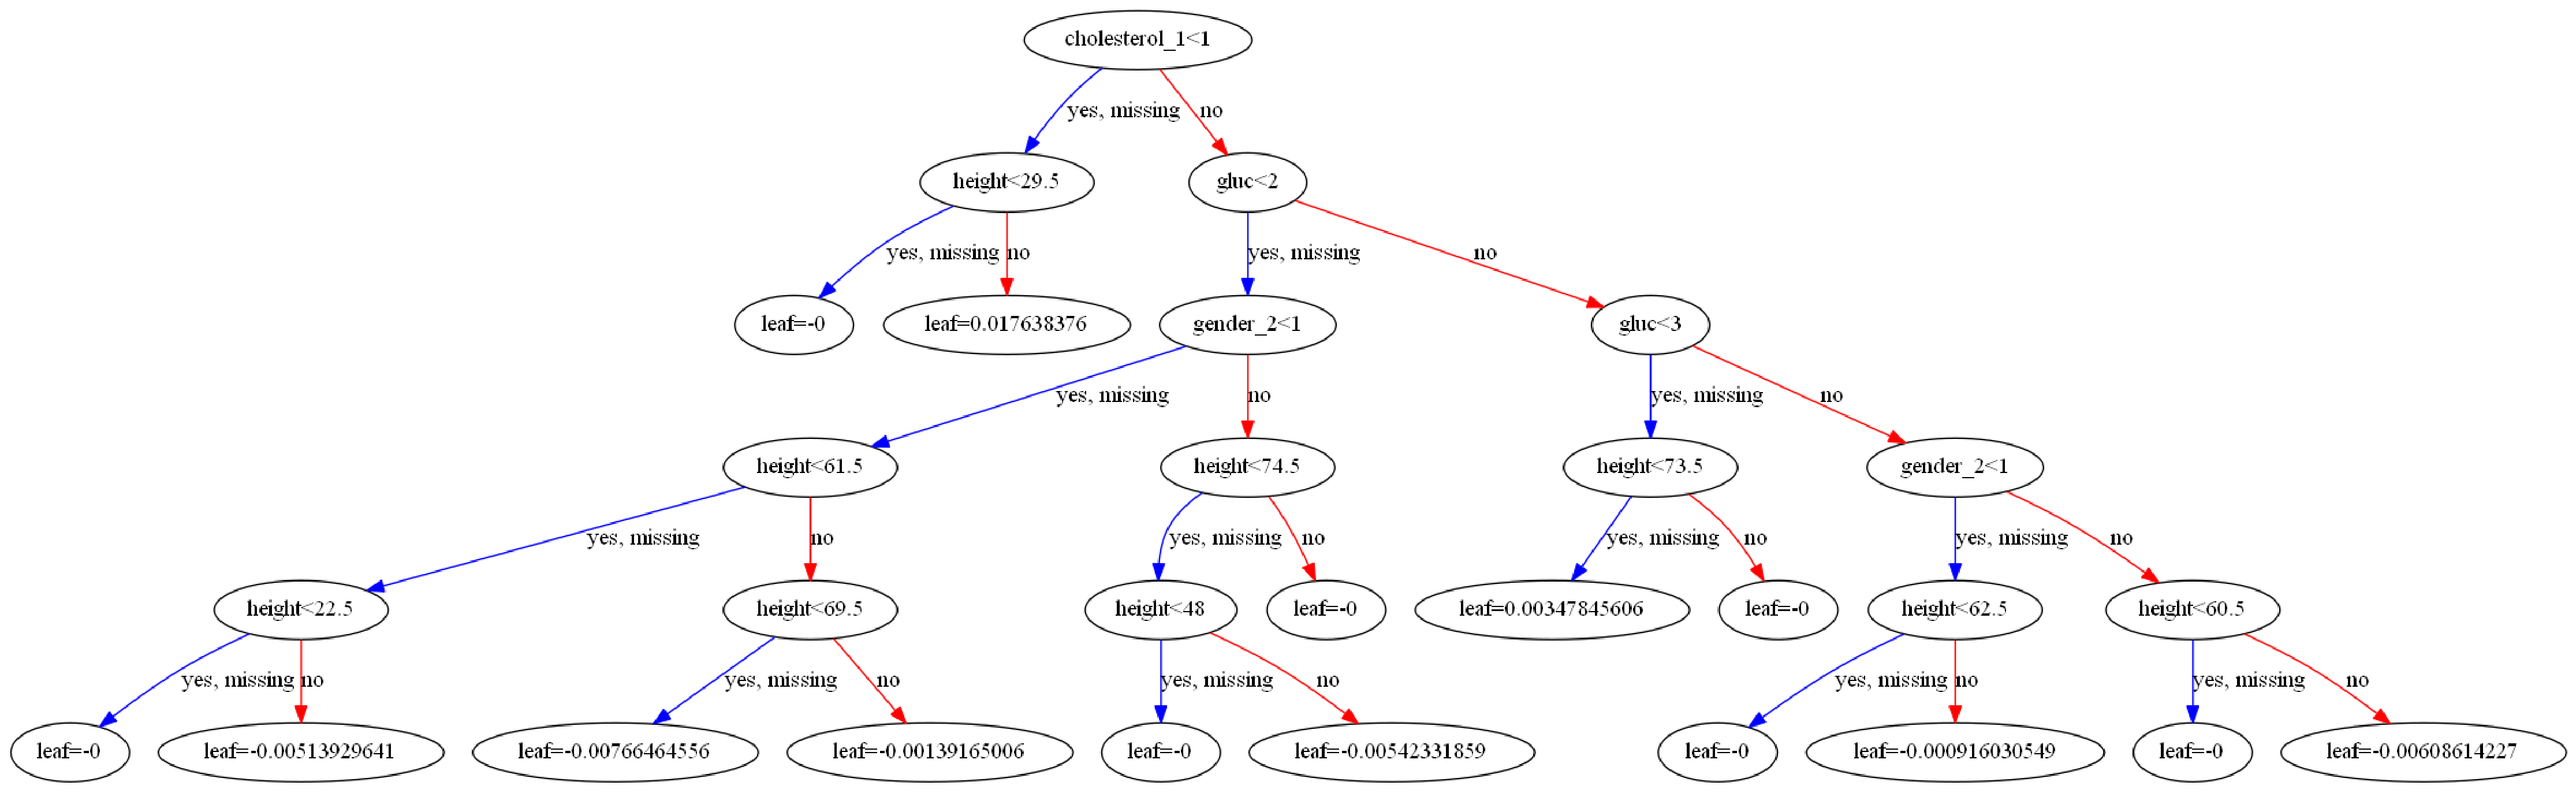

In [306]:
#plotting 
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [100,25]
plt.show()

In [307]:
# split data into train and test sets

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 73.77%


In [308]:
print(X.shape)
print(y.shape)

(70000, 15)
(70000,)


k: 1, Train/Test Score: 0.959/0.635
k: 3, Train/Test Score: 0.812/0.673
k: 5, Train/Test Score: 0.779/0.684
k: 7, Train/Test Score: 0.765/0.698
k: 9, Train/Test Score: 0.754/0.703
k: 11, Train/Test Score: 0.750/0.705
k: 13, Train/Test Score: 0.747/0.709
k: 15, Train/Test Score: 0.744/0.711
k: 17, Train/Test Score: 0.742/0.712
k: 19, Train/Test Score: 0.740/0.713


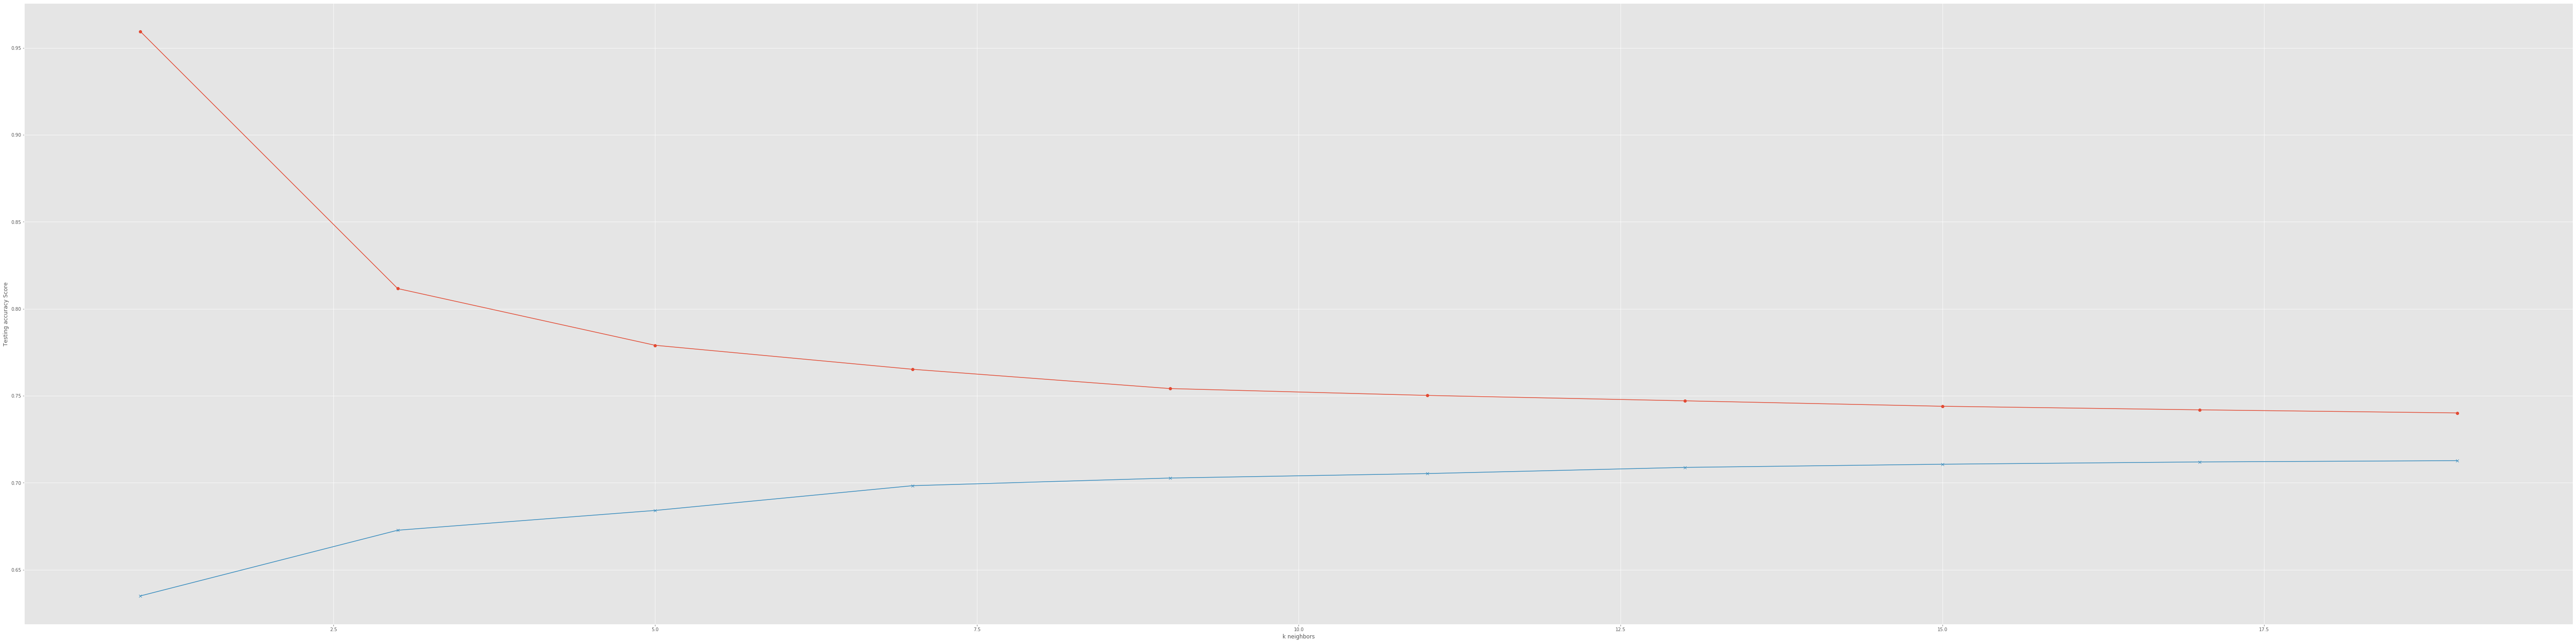

In [309]:
train_scores = []
test_scores = []
for k in range(1, 20, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

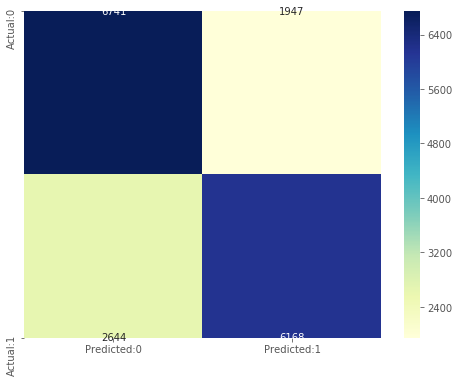

In [310]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
cm=confusion_matrix(y_test,predictions)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,6))
sn.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

The confusion matrix shows 6741+6168 = 12,909 correct predictions and 2802+1936= 4738 incorrect ones.

True Positives: 6168

True Negatives: 6741

False Positives: 1947 (Type I error)

False Negatives: 2644 ( Type II error)

In [311]:
len(y_test)

17500

In [312]:
y_pred

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [313]:
#for index, row in cardio1_encoded.iterrows():
    #print(row)
   # if index > 10:
       # break
 cardio1_encoded.iloc[0,]

age               50.000000
height            66.000000
weight           136.000000
ap_hi            110.000000
ap_lo             80.000000
gluc               1.000000
smoke              0.000000
alco               0.000000
active             1.000000
cardio             0.000000
BMI               21.948577
cholesterol_1      1.000000
cholesterol_2      0.000000
cholesterol_3      0.000000
gender_1           0.000000
gender_2           1.000000
Name: 0, dtype: float64